# Model Monitoring: How to use Prometheus and Grafana?
**A Workshop by MLReply MLOps Internal CoP (07.07.2022)** 

In this workshop, we will learn how to set up Prometheus and Grafana for real-time monitoring of ML models in production, particularly observing the trends and creating alerts.

## Prometheus
In a very short version, Prometheus is an open-source monitoring system with a time-series database. Prometheus is built to tackle monitoring with complex **multi-dimentional metrics** at the same time keeping it **operationaly simple**, **scalabe**, and **easy to query**. Prometheus comes with its own query language called PromQL. More info on: https://prometheus.io/

Keep in mind that Prometheus is designed for general system monitoring purposes and it has no ML-specific feature. However, its simplicity and scablability supports designing complex monitoring use cases for model monitoring too.

## Grafana
Grafana is the most common visualization tool (also open-source), particularly for time series. It provides a wide range of graph types and chart types for visualizing time series. More infor on: https://grafana.com/

## Model Monitoring
We assume that you are already familiar with the importance of model monitoring. You can learn more about it by reading this article: https://medium.com/p/1f6ee47be653

### Basic Architecture of a Monitoring System

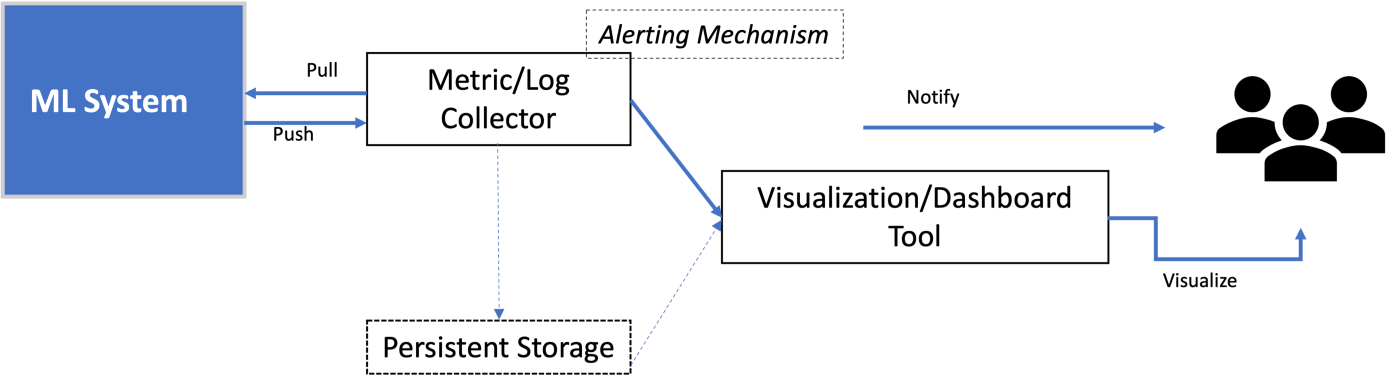

As you can see in the basic architecture, we need a metric collector, which we use Prometheus, and a visualization tool, here Grafana.

Please remember that a complete monitoring system has two mechanisms: monitoring by metrics and monitoring by logs. In this workshop, using Prometheus and Grafana stack, we set up the monitoring by metrics part. Monitoring by logs is another component that must be added to the system using a different tech stack.

# Let's Start

Here is the agenda:
* Importing a dataset and a model
* Setting up an app to serve the model
* Setting up an app to simulate requests
* Setting up Prometheus and Grafana
* Writing some queries using PromQL

## Dataset and Model

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [228]:
df = pd.read_csv("Stores.csv")

In [229]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [270]:
for x in np.arange(0.1, 1.0, 0.1):
    print(df['Daily_Customer_Count'].quantile(x), x)

440.0 0.1
560.0 0.2
650.0 0.30000000000000004
710.0 0.4
780.0 0.5
850.0 0.6
925.0 0.7000000000000001
1020.0 0.8
1140.0 0.9


In [230]:
df = df.drop(df.columns[[0, 1]], axis=1)
df.columns

Index(['Items_Available', 'Daily_Customer_Count', 'Store_Sales'], dtype='object')

In [231]:
df['Score'] = (df['Daily_Customer_Count'] * df['Daily_Customer_Count']) - ((df['Items_Available']-1782) * (df['Items_Available']-1782))

In [234]:
df['Success'] = df['Score'] > 856707

In [235]:
df['Success'] = df["Success"].astype(int)

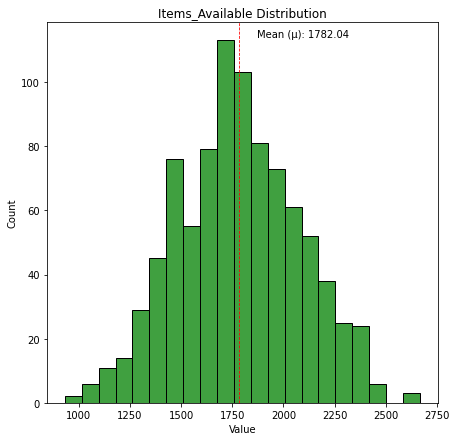

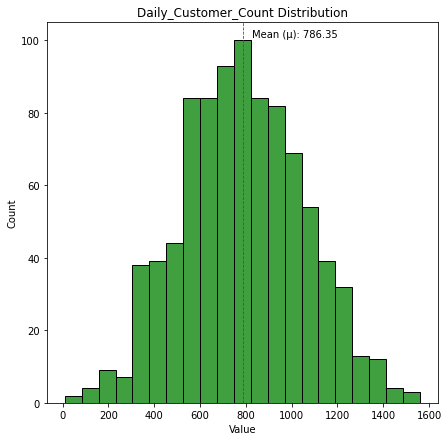

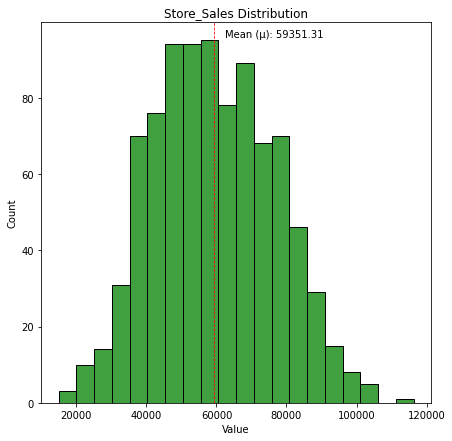

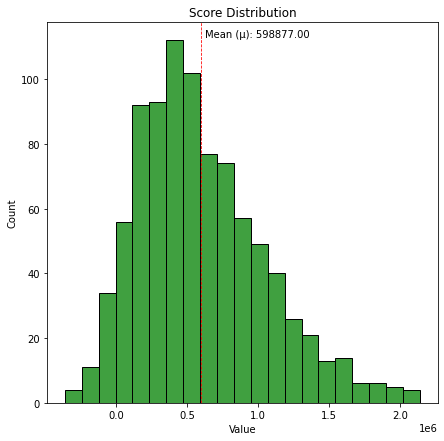

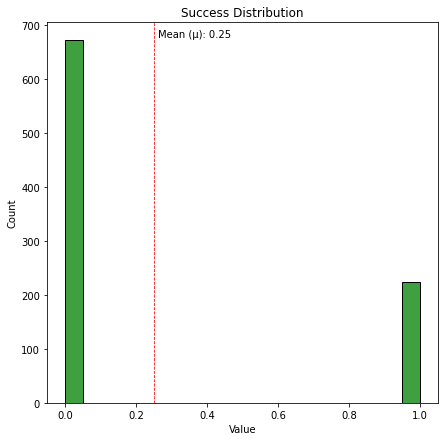

In [236]:
for column_name in df.columns:
  plt.figure(figsize=(7, 7))
  plt.title("{column_name} Distribution".format(column_name = column_name))
  sns.histplot(df[column_name], stat='count',color='green')
  plt.axvline(df[column_name].mean(), color='red', linestyle='--', linewidth=0.8)
  min_ylim, max_ylim = plt.ylim()
  plt.text(df[column_name].mean()*1.05, max_ylim*0.96, 'Mean (μ): {:.2f}'.format(df[column_name].mean()))
  plt.xlabel("Value")
  plt.ylabel("Count")
  plt.show()

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn import tree

In [238]:
clf = LocalOutlierFactor(n_neighbors=5, contamination='auto')
df['Out'] = clf.fit_predict(df)
Out = df[df['Out'] != 1]
train = df[df['Out'] == 1]

In [240]:
y = train['Success']
X = train.drop(['Store_Sales','Out', 'Score', 'Success'],axis=1)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

In [242]:
model = tree.DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [243]:
y_pred = model.predict(X_test)

In [254]:
f1_suc = f1_score(y_test, y_pred, average='binary', pos_label=1)
f1_unsuc = f1_score(y_test, y_pred, average='binary', pos_label=0)
precision_suc = precision_score(y_test, y_pred, average='binary', pos_label=1)
precision_unsuc = precision_score(y_test, y_pred, average='binary', pos_label=0)
recall_suc = recall_score(y_test, y_pred, average='binary', pos_label=1)
recall_unsuc = recall_score(y_test, y_pred, average='binary', pos_label=0)
print(f'Success Class f1: {f1_suc}, Normal Class f1: {f1_unsuc}')
print(f'Success Class Precision: {precision_suc}, Normal Class Precision: {precision_unsuc}')
print(f'Success Class Recall: {recall_suc}, Normal Class Recall: {recall_unsuc}')

Success Class f1: 0.9333333333333332, Normal Class f1: 0.9769230769230769
Success Class Precision: 0.8936170212765957, Normal Class Precision: 0.9921875
Success Class Recall: 0.9767441860465116, Normal Class Recall: 0.9621212121212122


In [74]:
import mlflow.sklearn

In [255]:
mlflow.sklearn.log_model(model, "model")

ModelInfo(artifact_path='model', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.9.5', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.1.1', 'serialization_format': 'cloudpickle', 'code': None}}, model_uri='runs:/5d5e7d761d134a85993cca3f43b84ba2/model', model_uuid='833988837f584154864bd9ddc5379901', run_id='5d5e7d761d134a85993cca3f43b84ba2', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-06-09 22:05:34.021927', mlflow_version='1.26.1')

In [256]:
import mlflow

In [257]:
loaded_model = mlflow.pyfunc.load_model("model")

In [258]:
y_pred_new = loaded_model.predict(X_test)
f1_score(y_test, y_pred_new, average='binary', pos_label=1)

0.9333333333333332

In [271]:
df[:20]

,Items_Available,Daily_Customer_Count,Store_Sales,Score,Success,Out
0,1961,530,66490,248859,0,1
1,1752,210,39820,43200,0,1
2,1609,720,54010,488471,0,1
3,1748,620,53730,383244,0,1
4,2111,450,46620,94259,0,1
5,1733,760,45260,575199,0,1
6,1858,1030,72240,1055124,1,1
7,1507,1020,37720,964775,1,1
8,1321,680,46310,249879,0,1
9,1235,1130,44150,977691,1,1
